In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzdis/Non_Demented/non_798.jpg
/kaggle/input/alzdis/Non_Demented/non_2592.jpg
/kaggle/input/alzdis/Non_Demented/non_318.jpg
/kaggle/input/alzdis/Non_Demented/non_207.jpg
/kaggle/input/alzdis/Non_Demented/non_2248.jpg
/kaggle/input/alzdis/Non_Demented/non_2733.jpg
/kaggle/input/alzdis/Non_Demented/non_2791.jpg
/kaggle/input/alzdis/Non_Demented/non_2393.jpg
/kaggle/input/alzdis/Non_Demented/non_106.jpg
/kaggle/input/alzdis/Non_Demented/non_2986.jpg
/kaggle/input/alzdis/Non_Demented/non_707.jpg
/kaggle/input/alzdis/Non_Demented/non_756.jpg
/kaggle/input/alzdis/Non_Demented/non_1199.jpg
/kaggle/input/alzdis/Non_Demented/non_1758.jpg
/kaggle/input/alzdis/Non_Demented/non_2615.jpg
/kaggle/input/alzdis/Non_Demented/non_1781.jpg
/kaggle/input/alzdis/Non_Demented/non_2042.jpg
/kaggle/input/alzdis/Non_Demented/non_1765.jpg
/kaggle/input/alzdis/Non_Demented/non_179.jpg
/kaggle/input/alzdis/Non_Demented/non_6.jpg
/kaggle/input/alzdis/Non_Demented/non_1154.jpg
/kaggle/input/alzdis/No

In [2]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
import random
import cv2
import warnings
warnings.filterwarnings("ignore")

In [4]:
total_classes = os.listdir("/kaggle/input/alzdis")
print(total_classes)

['Non_Demented', 'Mild_Demented', 'Moderate_Demented', 'Very_Mild_Demented']


In [5]:
# Total number of images per class.
images_path = Path("/kaggle/input/alzdis")

for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* Non_Demented = 3200 images
* Mild_Demented = 896 images
* Moderate_Demented = 64 images
* Very_Mild_Demented = 2240 images


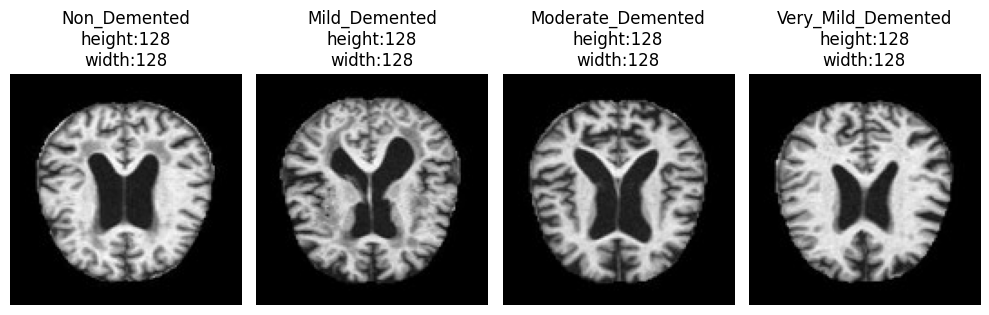

In [6]:
# Let's display 1 image per class.

fig,ax = plt.subplots(1,4,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):
  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show()

In [7]:
batch_size = 32
img_height = 299
img_width = 299

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


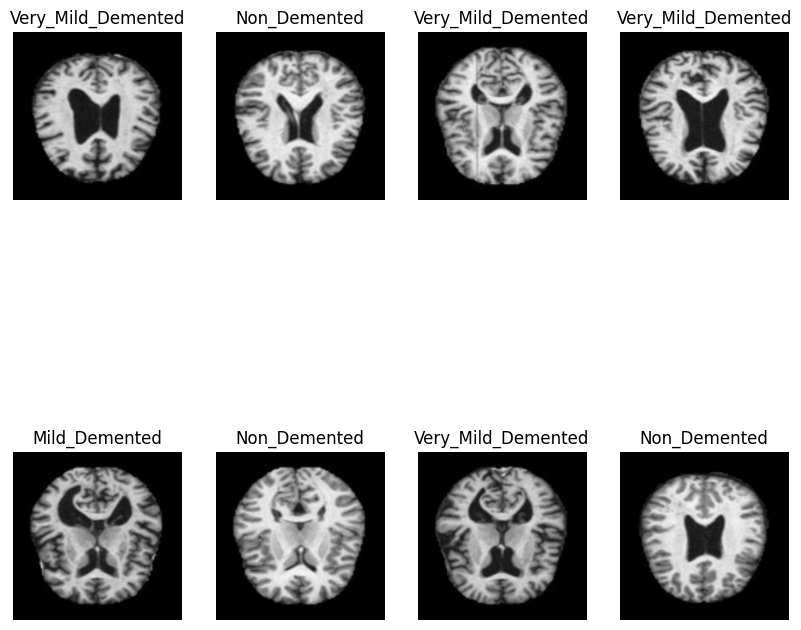

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 299, 299, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardizing the dataset**

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in '[0,1]'

print(np.min(first_image), np.max(first_image))

0.0 0.983595


**Import InceptionV3**

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [17]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Number of output classes
num_classes = len(class_names)

# Load the InceptionV3 model without the top layers
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units and activation function as needed
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [19]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 23,870,628 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [21]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
    )

Epoch 1/100


I0000 00:00:1728502445.250481     130 service.cc:145] XLA service 0x7c5b6c002c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728502445.250539     130 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728502445.250543     130 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728502492.861982     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 ━━━━━━━━━━━━━━━━━━━━ 155s 446ms/step - accuracy: 0.5181 - loss: 1.1676 - val_accuracy: 0.5508 - val_loss: 1.3282
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 408ms/step - accuracy: 0.6910 - loss: 0.7080 - val_accuracy: 0.1883 - val_loss: 4.8299
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 408ms/step - accuracy: 0.7802 - loss: 0.5198 - val_accuracy: 0.6906 - val_loss: 1.7154
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 409ms/step - accuracy: 0.8670 - loss: 0.3330 - val_accuracy: 0.7633 - val_loss: 0.5755
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 408ms/step - accuracy: 0.9507 - loss: 0.1463 - val_accuracy: 0.7125 - val_loss: 1.1156
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 409ms/step - accuracy: 0.9575 - loss: 0.1167 - val_accuracy: 0.7266 - val_loss: 1.1048
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 408ms/step - accuracy: 0.9723 - loss: 0.0810 - val_accuracy: 0.6906 - val_loss: 1.1873
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 408ms/step - accuracy: 0.9725 - loss: 0.07

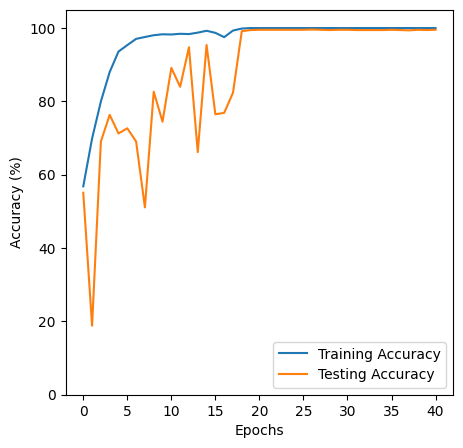

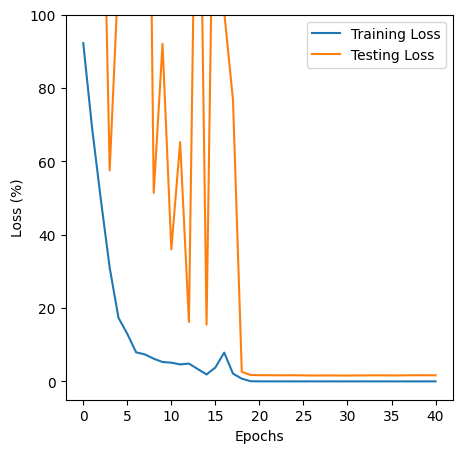

In [22]:
import matplotlib.pyplot as plt

acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]

loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]

epochs_range = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
#plt.title("Training and Validation Accuracy")
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim([0, 105])  # Set the y-axis limit from 0 to 100
# Save the accuracy plot
plt.savefig('InceptionV3_100_training_testing_accuracy_before_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
plt.ylabel('Loss (%)')
plt.xlabel('Epochs')
plt.ylim([-5, 100])
# Save the loss plot
plt.savefig('InceptionV3_100_training_testing_loss_before_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step


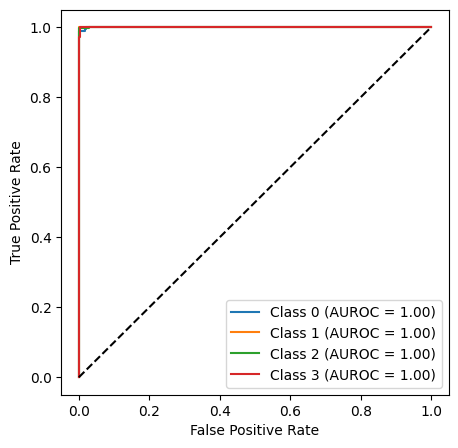

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and true labels
y_pred_logits = model.predict(val_ds)
y_pred_probs = tf.nn.softmax(y_pred_logits).numpy()  # Convert logits to probabilities
y_true = np.concatenate([y for x, y in val_ds], axis=0)  # True labels for the validation set

# If it's a multi-class problem, binarize the labels for AUROC calculation
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Create a single figure for plotting all ROC curves
plt.figure(figsize=(5, 5))

# Calculate AUROC for each class and plot
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUROC = {roc_auc:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the combined plot with all ROC curves
plt.savefig('InceptionV3_100_AUROC_before_Data_Aug.png')
plt.show()


**Augmentation**

In [24]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

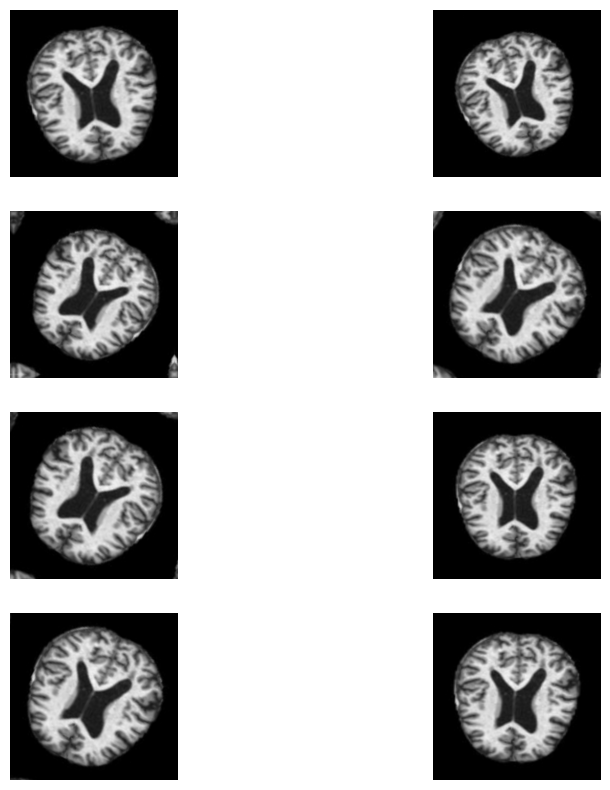

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4,2, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Add a dropout layer**

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Number of output classes
num_classes = len(class_names)

# Load the InceptionV3 model without the top layers
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299, 299, 3)
)

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units and activation function as needed
x = Dropout(0.2)(x)  # Adding Dropout layer with 20% rate
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


In [27]:
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [28]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 147, 147,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 23,870,628 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [35]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    #callbacks=[early_stopping]
)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 68s 425ms/step - accuracy: 0.6435 - loss: 0.7837 - val_accuracy: 0.5289 - val_loss: 3.1093
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 409ms/step - accuracy: 0.7898 - loss: 0.5258 - val_accuracy: 0.4109 - val_loss: 10.8912
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 409ms/step - accuracy: 0.8867 - loss: 0.3164 - val_accuracy: 0.6320 - val_loss: 1.7290
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 66s 410ms/step - accuracy: 0.9224 - loss: 0.2082 - val_accuracy: 0.8242 - val_loss: 1.2975
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 83s 413ms/step - accuracy: 0.9536 - loss: 0.1392 - val_accuracy: 0.9172 - val_loss: 0.3029
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 407ms/step - accuracy: 0.9684 - loss: 0.0931 - val_accuracy: 0.7008 - val_loss: 1.5384
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 65s 409ms/step - accuracy: 0.9793 - loss: 0.0604 - val_accuracy: 0.5352 - val_loss: 5.1545
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 66s 410ms/step - accuracy: 0.9712 

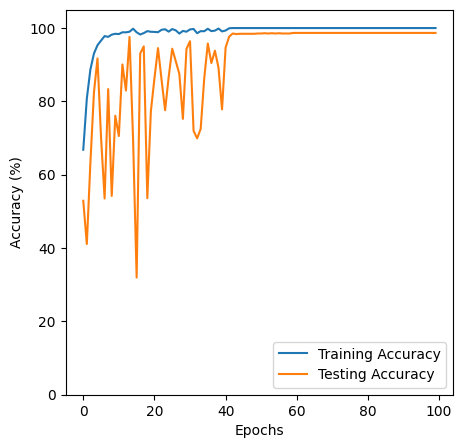

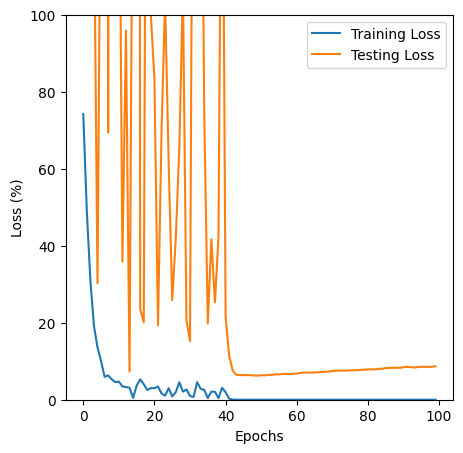

In [37]:
import matplotlib.pyplot as plt

acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]

loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]

epochs_range = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
#plt.title("Training and Validation Accuracy")
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim([0, 105])  # Set the y-axis limit from 0 to 100
# Save the accuracy plot
plt.savefig('InceptionV3_100_training_testing_accuracy_after_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
plt.ylabel('Loss (%)')
plt.xlabel('Epochs')
plt.ylim([0, 100])
# Save the loss plot
plt.savefig('InceptionV3_100_training_testing_loss_after_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step


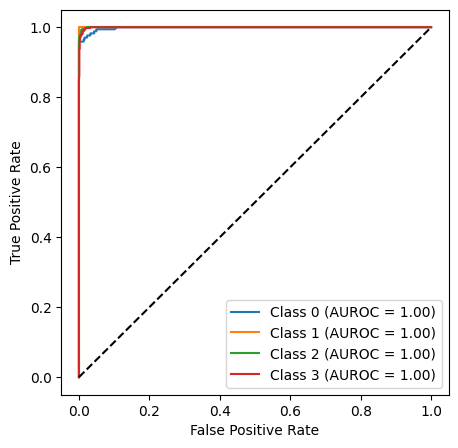

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predictions and true labels
y_pred_logits = model.predict(val_ds)
y_pred_probs = tf.nn.softmax(y_pred_logits).numpy()  # Convert logits to probabilities
y_true = np.concatenate([y for x, y in val_ds], axis=0)  # True labels for the validation set

# If it's a multi-class problem, binarize the labels for AUROC calculation
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Create a single figure for plotting all ROC curves
plt.figure(figsize=(5, 5))

# Calculate AUROC for each class and plot
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUROC = {roc_auc:.2f})')

# Plot the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Show the combined plot with all ROC curves
plt.savefig('InceptionV3_100_AUROC_after_Data_Aug.png')
plt.show()


In [40]:
model.evaluate(train_ds)

160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 1.0000 - loss: 4.7250e-08


[2.9196707274081746e-08, 1.0]

In [41]:
model.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.9889 - loss: 0.0536


[0.08702428638935089, 0.9867187738418579]